# Fine-Tune DistilBERT for 3-Class Email Classification
This notebook covers loading your dataset, preprocessing, fine-tuning a DistilBERT model on three labels (`legit`, `spam`, `phishing`), and evaluating its performance.


In [2]:
!pip install datasets -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 4.5 MB/s eta 0:00:00a 0:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
cesium 0.12.4 requires numpy<3.0,>=2.0, but you have numpy 1.26.4 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-nvrtc-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-nvrtc-cu12 12.5.82 which is incomp

In [3]:
import pandas as pd
from datasets import Dataset, ClassLabel, Features, Value
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report
import numpy as np
import torch

In [ ]:
!pip install gdown

In [4]:
!wget "https://drive.usercontent.google.com/download?id=1FTWJThUan4NCIMhgDoYhnhUQY5nVJoex&export=download&authuser=0&confirm=t&uuid=7f96ff72-5411-4671-97ea-1a783f671d97&at=AN8xHorA4bAp-YLgKI1yuHmGKGhD%3A1753111253598" -O 'combined_dataset.parquet'

--2025-07-21 15:28:07--  https://drive.usercontent.google.com/download?id=1FTWJThUan4NCIMhgDoYhnhUQY5nVJoex&export=download&authuser=0&confirm=t&uuid=7f96ff72-5411-4671-97ea-1a783f671d97&at=AN8xHorA4bAp-YLgKI1yuHmGKGhD%3A1753111253598
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 173.194.195.132, 2607:f8b0:4001:c11::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|173.194.195.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 196071974 (187M) [application/octet-stream]
Saving to: ‘combined_dataset.parquet’

combined_dataset.pa 100%[===================>] 186.99M   120MB/s    in 1.6s    

2025-07-21 15:28:09 (120 MB/s) - ‘combined_dataset.parquet’ saved [196071974/196071974]



# Preparing the dataset

In [5]:
dataset = pd.read_parquet("/kaggle/working/combined_dataset.parquet")

# Shuffling the dataset

In [6]:
dataset = dataset.sample(frac=1, random_state=99).reset_index(drop=True)

## The dataset has fields: 'text' and 'label' (0=legit, 1=spam, 2=phishing)

✅ 3. Encode string labels

In [7]:
label_names = sorted(dataset['label'].unique())  # ['legit', 'phishing', 'spam'] for example
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}
dataset['label'] = dataset['label'].map(label2id)



### 📦 4. Convert to Hugging Face Dataset

In [8]:
label_names = dataset['label'].unique().astype(str).tolist()
features = Features({
    'text': Value('string'),
    'label': ClassLabel(names=label_names)
})
ds = Dataset.from_pandas(dataset[['text', 'label']], features=features)


### ✂️ 5. Train-test split

In [10]:
split = ds.train_test_split(test_size=0.2, stratify_by_column="label", seed=42)
train_ds = split["train"]
test_ds = split["test"]

## 🧠 6. Load tokenizer & tokenize

In [11]:
datasetcheckpoint = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(datasetcheckpoint)

def tokenize(batch):
    return tokenizer(batch["text"], truncation=True, padding=True, max_length=128)

train_ds = train_ds.map(tokenize, batched=True)
test_ds = test_ds.map(tokenize, batched=True)

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/138480 [00:00<?, ? examples/s]

Map:   0%|          | 0/34620 [00:00<?, ? examples/s]

## 🧠 7. Load model (3-class classification)

In [12]:
label_list = dataset['label'].unique().tolist()

# Make sure you convert everything to plain Python types
label2id = {str(label): int(i) for i, label in enumerate(label_list)}
id2label = {int(i): str(label) for i, label in enumerate(label_list)}

# Now load the model
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    datasetcheckpoint,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## ⚙️ 8. Define metrics

In [13]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    report = classification_report(labels, preds, target_names=label_names, output_dict=True)
    return {
        "accuracy": report["accuracy"],
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1": report["weighted avg"]["f1-score"]
    }

## ⚙️ 9. Training arguments

In [14]:
# training_args = TrainingArguments(
#     output_dir="./results",
#     eval_strategy="epoch",
#     per_device_train_batch_size=16,
#     per_device_eval_batch_size=16,
#     num_train_epochs=4,
#     weight_decay=0.01,
#     logging_dir="./logs",
#     logging_steps=10,
#     save_strategy="no",
#     load_best_model_at_end=False,
#     gradient_accumulation_steps=2,
#     fp16=True
# )
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="no",
    gradient_accumulation_steps=2,
    report_to=[], # ✅ Important: disable **all** loggers
    fp16=True
)

## 🏋️‍♂️ 10. Trainer

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

/tmp/ipykernel_36/4292890155.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


### 🚀 11. Train

In [16]:
trainer.train()

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.059300,0.071314,0.975188,0.975351,0.975188,0.975251
2,0.040700,0.105833,0.978047,0.978213,0.978047,0.978105
3,0.040500,0.233599,0.980243,0.980217,0.980243,0.980205
4,0.016600,0.252408,0.981051,0.981121,0.981051,0.981080
5,0.047200,0.257346,0.982582,0.982571,0.982582,0.982576


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


TrainOutput(global_step=10820, training_loss=0.07248784778646966, metrics={'train_runtime': 5563.2434, 'train_samples_per_second': 124.46, 'train_steps_per_second': 1.945, 'total_flos': 2.29305156332544e+16, 'train_loss': 0.07248784778646966, 'epoch': 5.0})

## 📊 12. Evaluate

In [17]:
eval_results = trainer.evaluate()
print(eval_results)

/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


{'eval_loss': 0.2573458254337311, 'eval_accuracy': 0.982582322357019, 'eval_precision': 0.9825714857927876, 'eval_recall': 0.982582322357019, 'eval_f1': 0.9825758895384278, 'eval_runtime': 88.0181, 'eval_samples_per_second': 393.328, 'eval_steps_per_second': 12.293, 'epoch': 5.0}


# 📌 13. Save the model

In [18]:
model.save_pretrained("email_guardian-model")
tokenizer.save_pretrained("email_guardian-model")

('email_guardian-model/tokenizer_config.json',
 'email_guardian-model/special_tokens_map.json',
 'email_guardian-model/vocab.txt',
 'email_guardian-model/added_tokens.json',
 'email_guardian-model/tokenizer.json')

In [19]:

import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Get predictions on the test set
predictions = trainer.predict(test_ds)
y_pred = np.argmax(predictions.predictions, axis=-1)
y_true = predictions.label_ids

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)


/usr/local/lib/python3.11/dist-packages/torch/nn/parallel/_functions.py:70: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn(


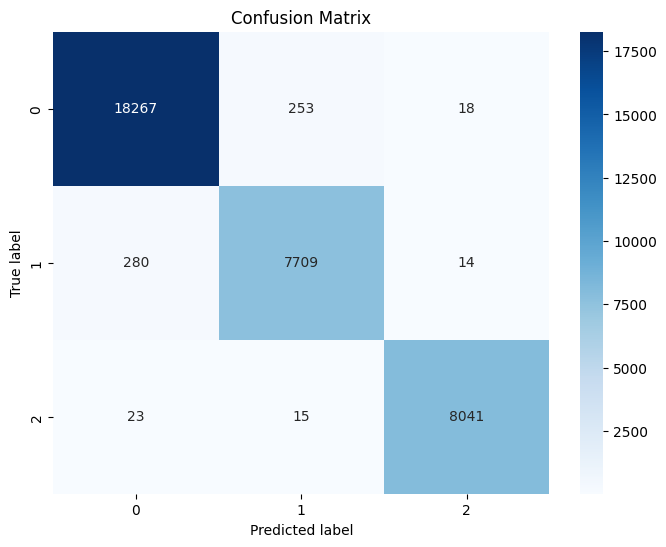

In [20]:

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_names, yticklabels=label_names)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix')
plt.show()

# Access training logs
log_history = trainer.state.log_history

# Extract loss and evaluation metrics
train_loss = [log['loss'] for log in log_history if 'loss' in log]
eval_loss = [log['eval_loss'] for log in log_history if 'eval_loss' in log]
eval_accuracy = [log['eval_accuracy'] for log in log_history if 'eval_accuracy' in log]


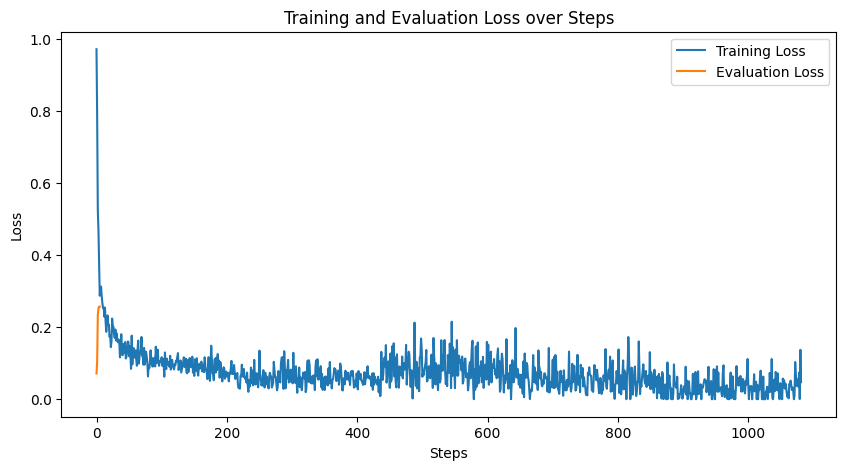

In [21]:

# Plot training and evaluation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
if eval_loss: # Only plot if eval_loss exists (evaluation strategy is not "no")
    plt.plot(eval_loss, label='Evaluation Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Evaluation Loss over Steps')
plt.legend()
plt.show()



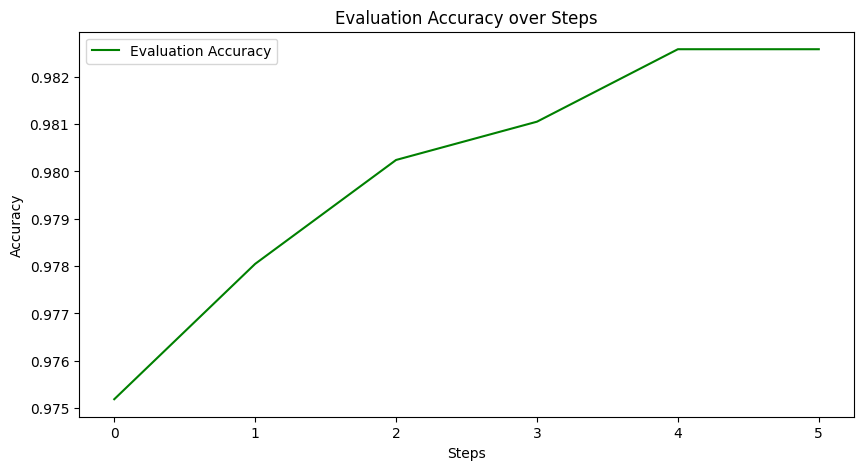

In [22]:
# Plot evaluation accuracy
if eval_accuracy: # Only plot if eval_accuracy exists
    plt.figure(figsize=(10, 5))
    plt.plot(eval_accuracy, label='Evaluation Accuracy', color='green')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.title('Evaluation Accuracy over Steps')
    plt.legend()
    plt.show()


In [23]:
!zip -r email_guardian-model.zip email_guardian-model/

  adding: email_guardian-model/ (stored 0%)
  adding: email_guardian-model/vocab.txt (deflated 53%)
  adding: email_guardian-model/special_tokens_map.json (deflated 42%)
  adding: email_guardian-model/tokenizer.json (deflated 71%)
  adding: email_guardian-model/tokenizer_config.json (deflated 75%)
  adding: email_guardian-model/model.safetensors

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


 (deflated 8%)
  adding: email_guardian-model/config.json (deflated 48%)


In [25]:
!ls -1 /kaggle/working/email_guardian-model

config.json
model.safetensors
special_tokens_map.json
tokenizer_config.json
tokenizer.json
vocab.txt


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
